# Write results to `tex` files
---

This notebook contains the workings out for generating our results in the $k$-modes write-up.

We will be examining a selection of well-known categorical datasets and running our algorithm against them to test for their ability in:

- **clustering** (using the objective function and silhouette score)
- computational **speed**

### Each set of results will be found by manipulating some `pandas.DataFrame` and then written to a `tex` file.

In [1]:
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbn
import time

%matplotlib inline
sbn.set_palette('colorblind')

# Read in datasets

In [35]:
soybean = pd.read_csv('../data/soybean.csv', na_values=['?', 'dna'], dtype='object')
mushroom = pd.read_csv('../data/mushroom.csv', dtype='object')
zoo = pd.read_csv('../data/zoo.csv', dtype='object')
breast_cancer = pd.read_csv('../data/breast_cancer.csv', dtype='object')
vehicle = pd.read_csv('../data/vehicle.csv', dtype='object')

for dataset in [soybean, mushroom, zoo, breast_cancer, vehicle]:
    dataset.dropna(axis=0, inplace=True)

# Plot results

In [17]:
def get_epoch_plot(dataset, name, class_col='class'):

    data, labels = dataset.drop(class_col, axis=1), dataset[class_col]
    k = labels.nunique()

    fig, ax = plt.subplots(1, figsize=(14, 10), dpi=300)

    for init in ['cao', 'huang', 'random', 'matching_best', 'matching_worst', 'matching_random']:

        np.random.seed(0)
        km = KModes(k, init=init, n_init=25)
        km.fit_predict(data)
        costs = km.epoch_costs_

        if 'matching' not in init:
            marker='--'
        else:
            marker='-'

        ax.plot(range(len(costs)), costs, marker, label=init.replace('_', ' ').title())
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Cost')
        ax.legend()
        ax.set_title(f'Epoch costs on the {name} dataset with $k={k}$')
        plt.savefig(f'../img/epoch_plot_{name.replace(" ", "_")}.pdf');

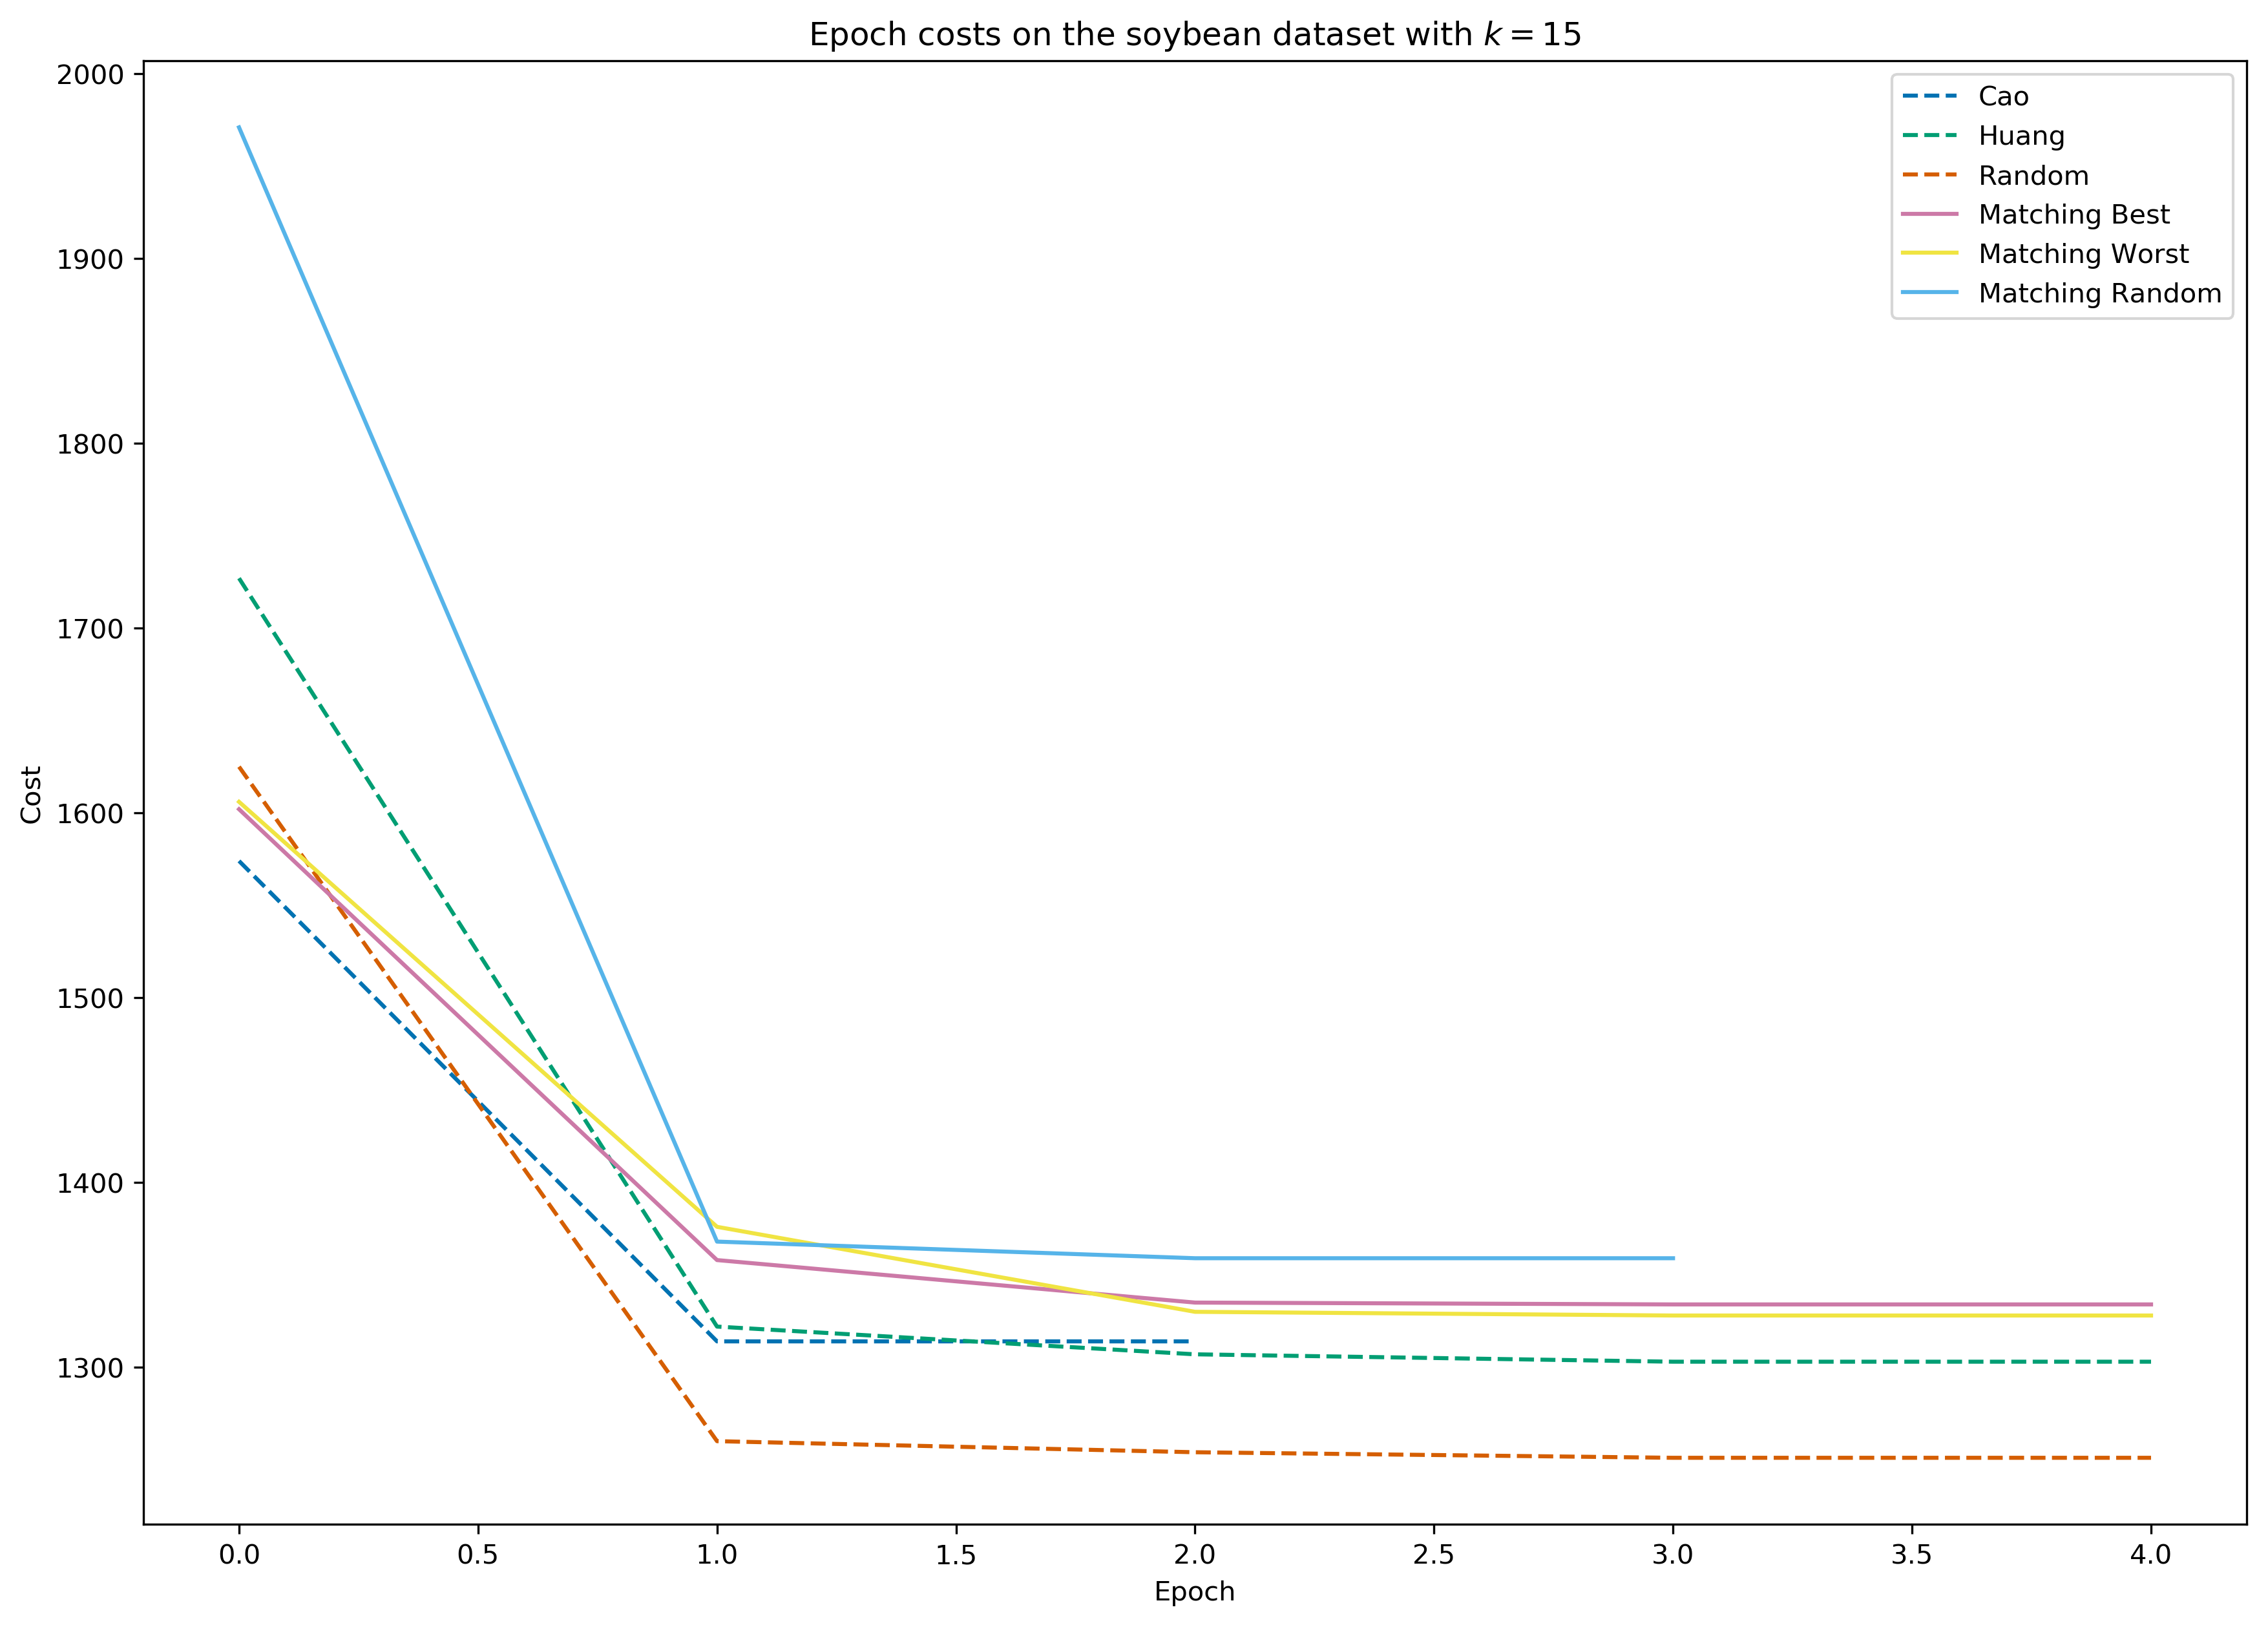

In [18]:
get_epoch_plot(soybean, 'soybean')

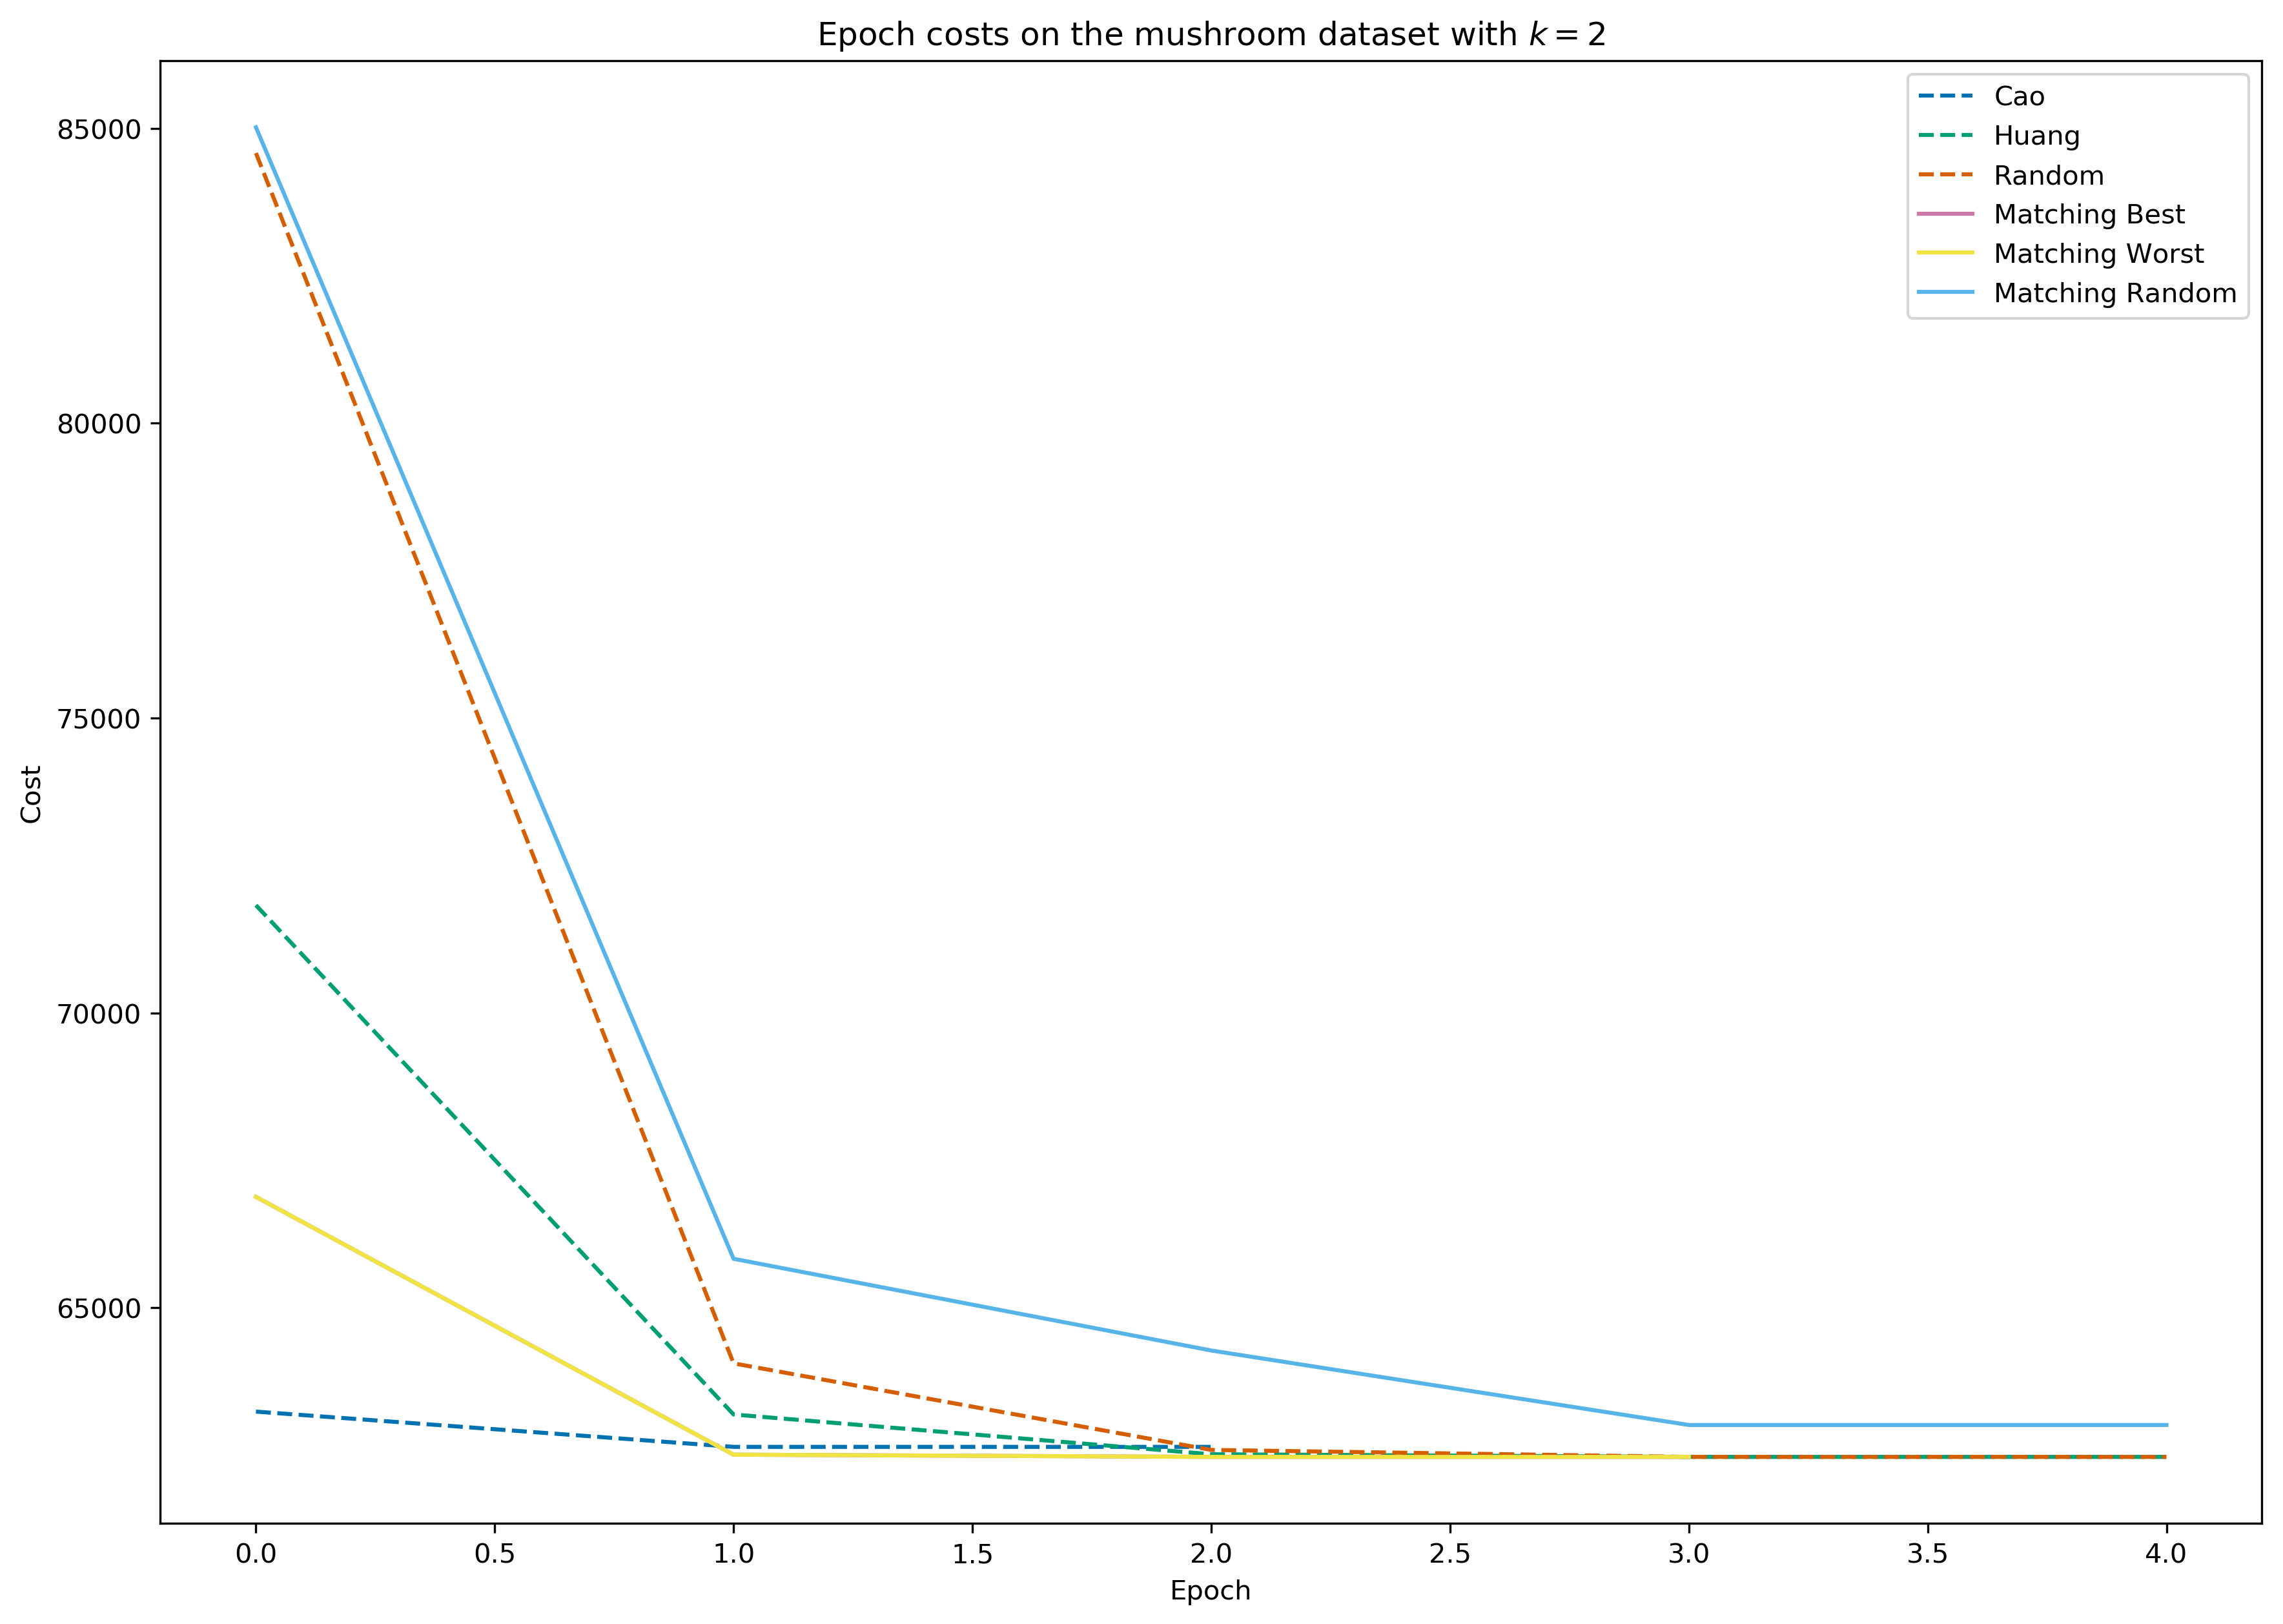

In [19]:
get_epoch_plot(mushroom, 'mushroom')

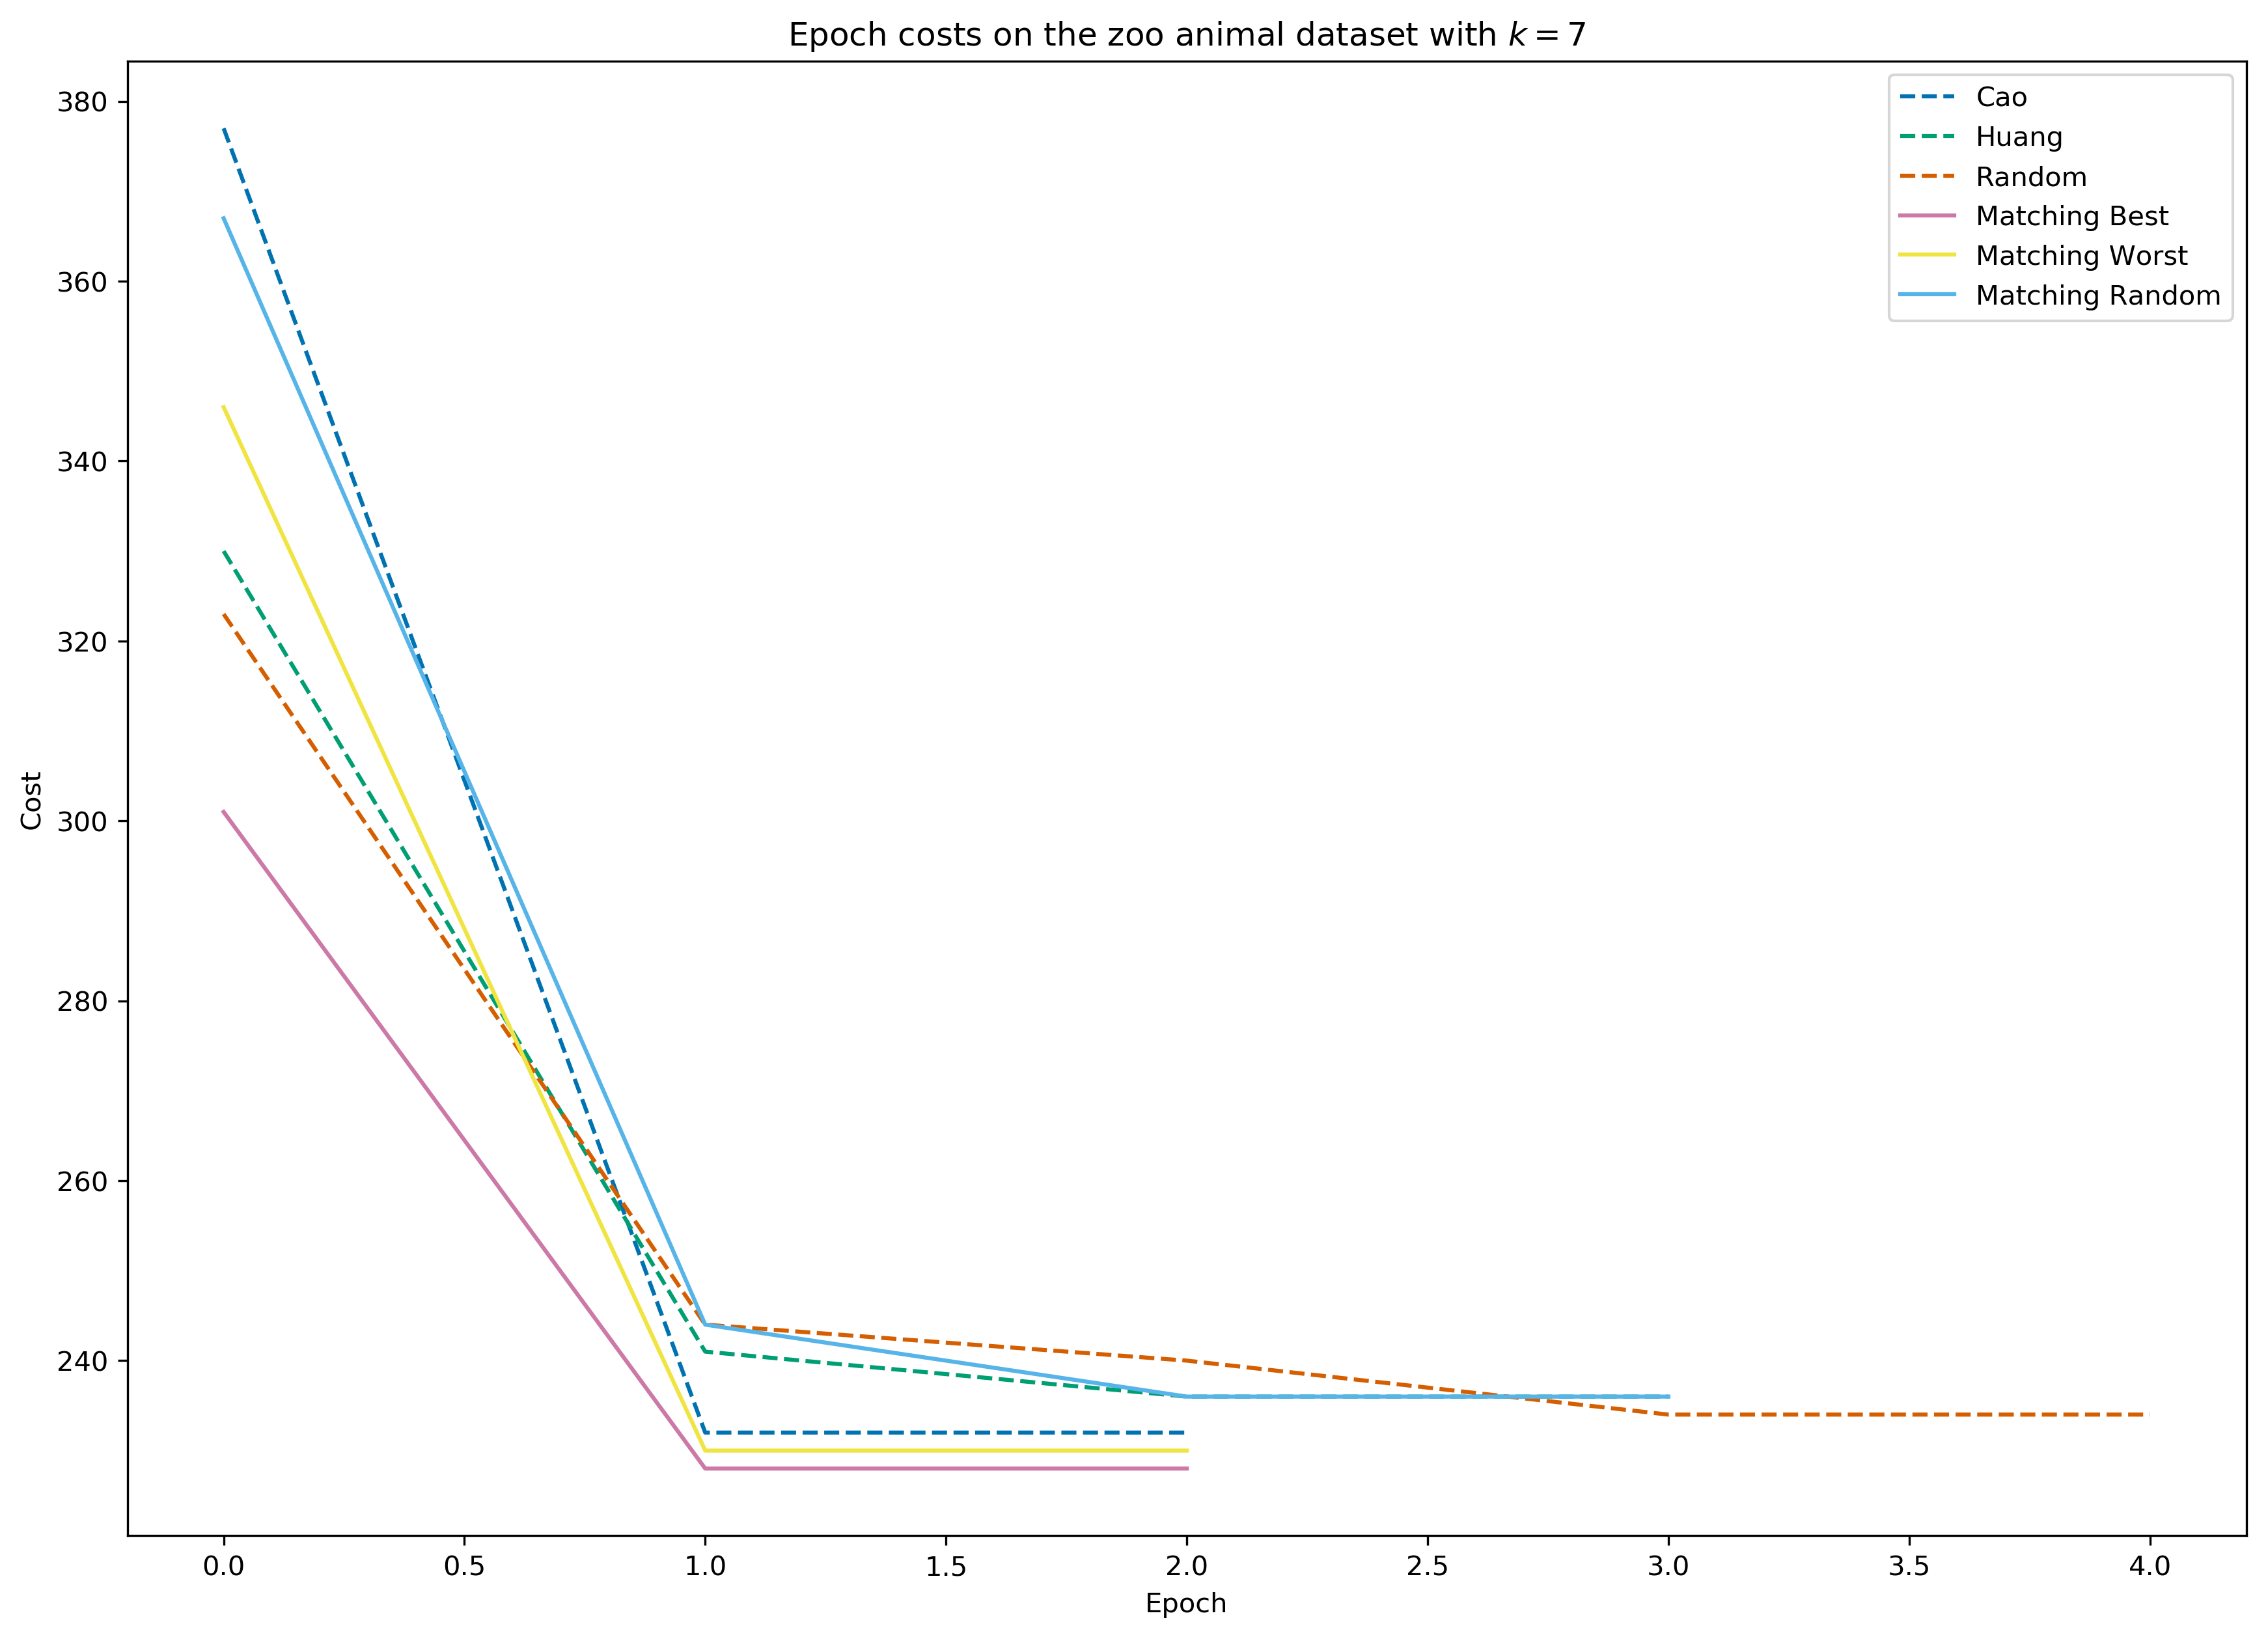

In [20]:
get_epoch_plot(zoo, 'zoo animal')

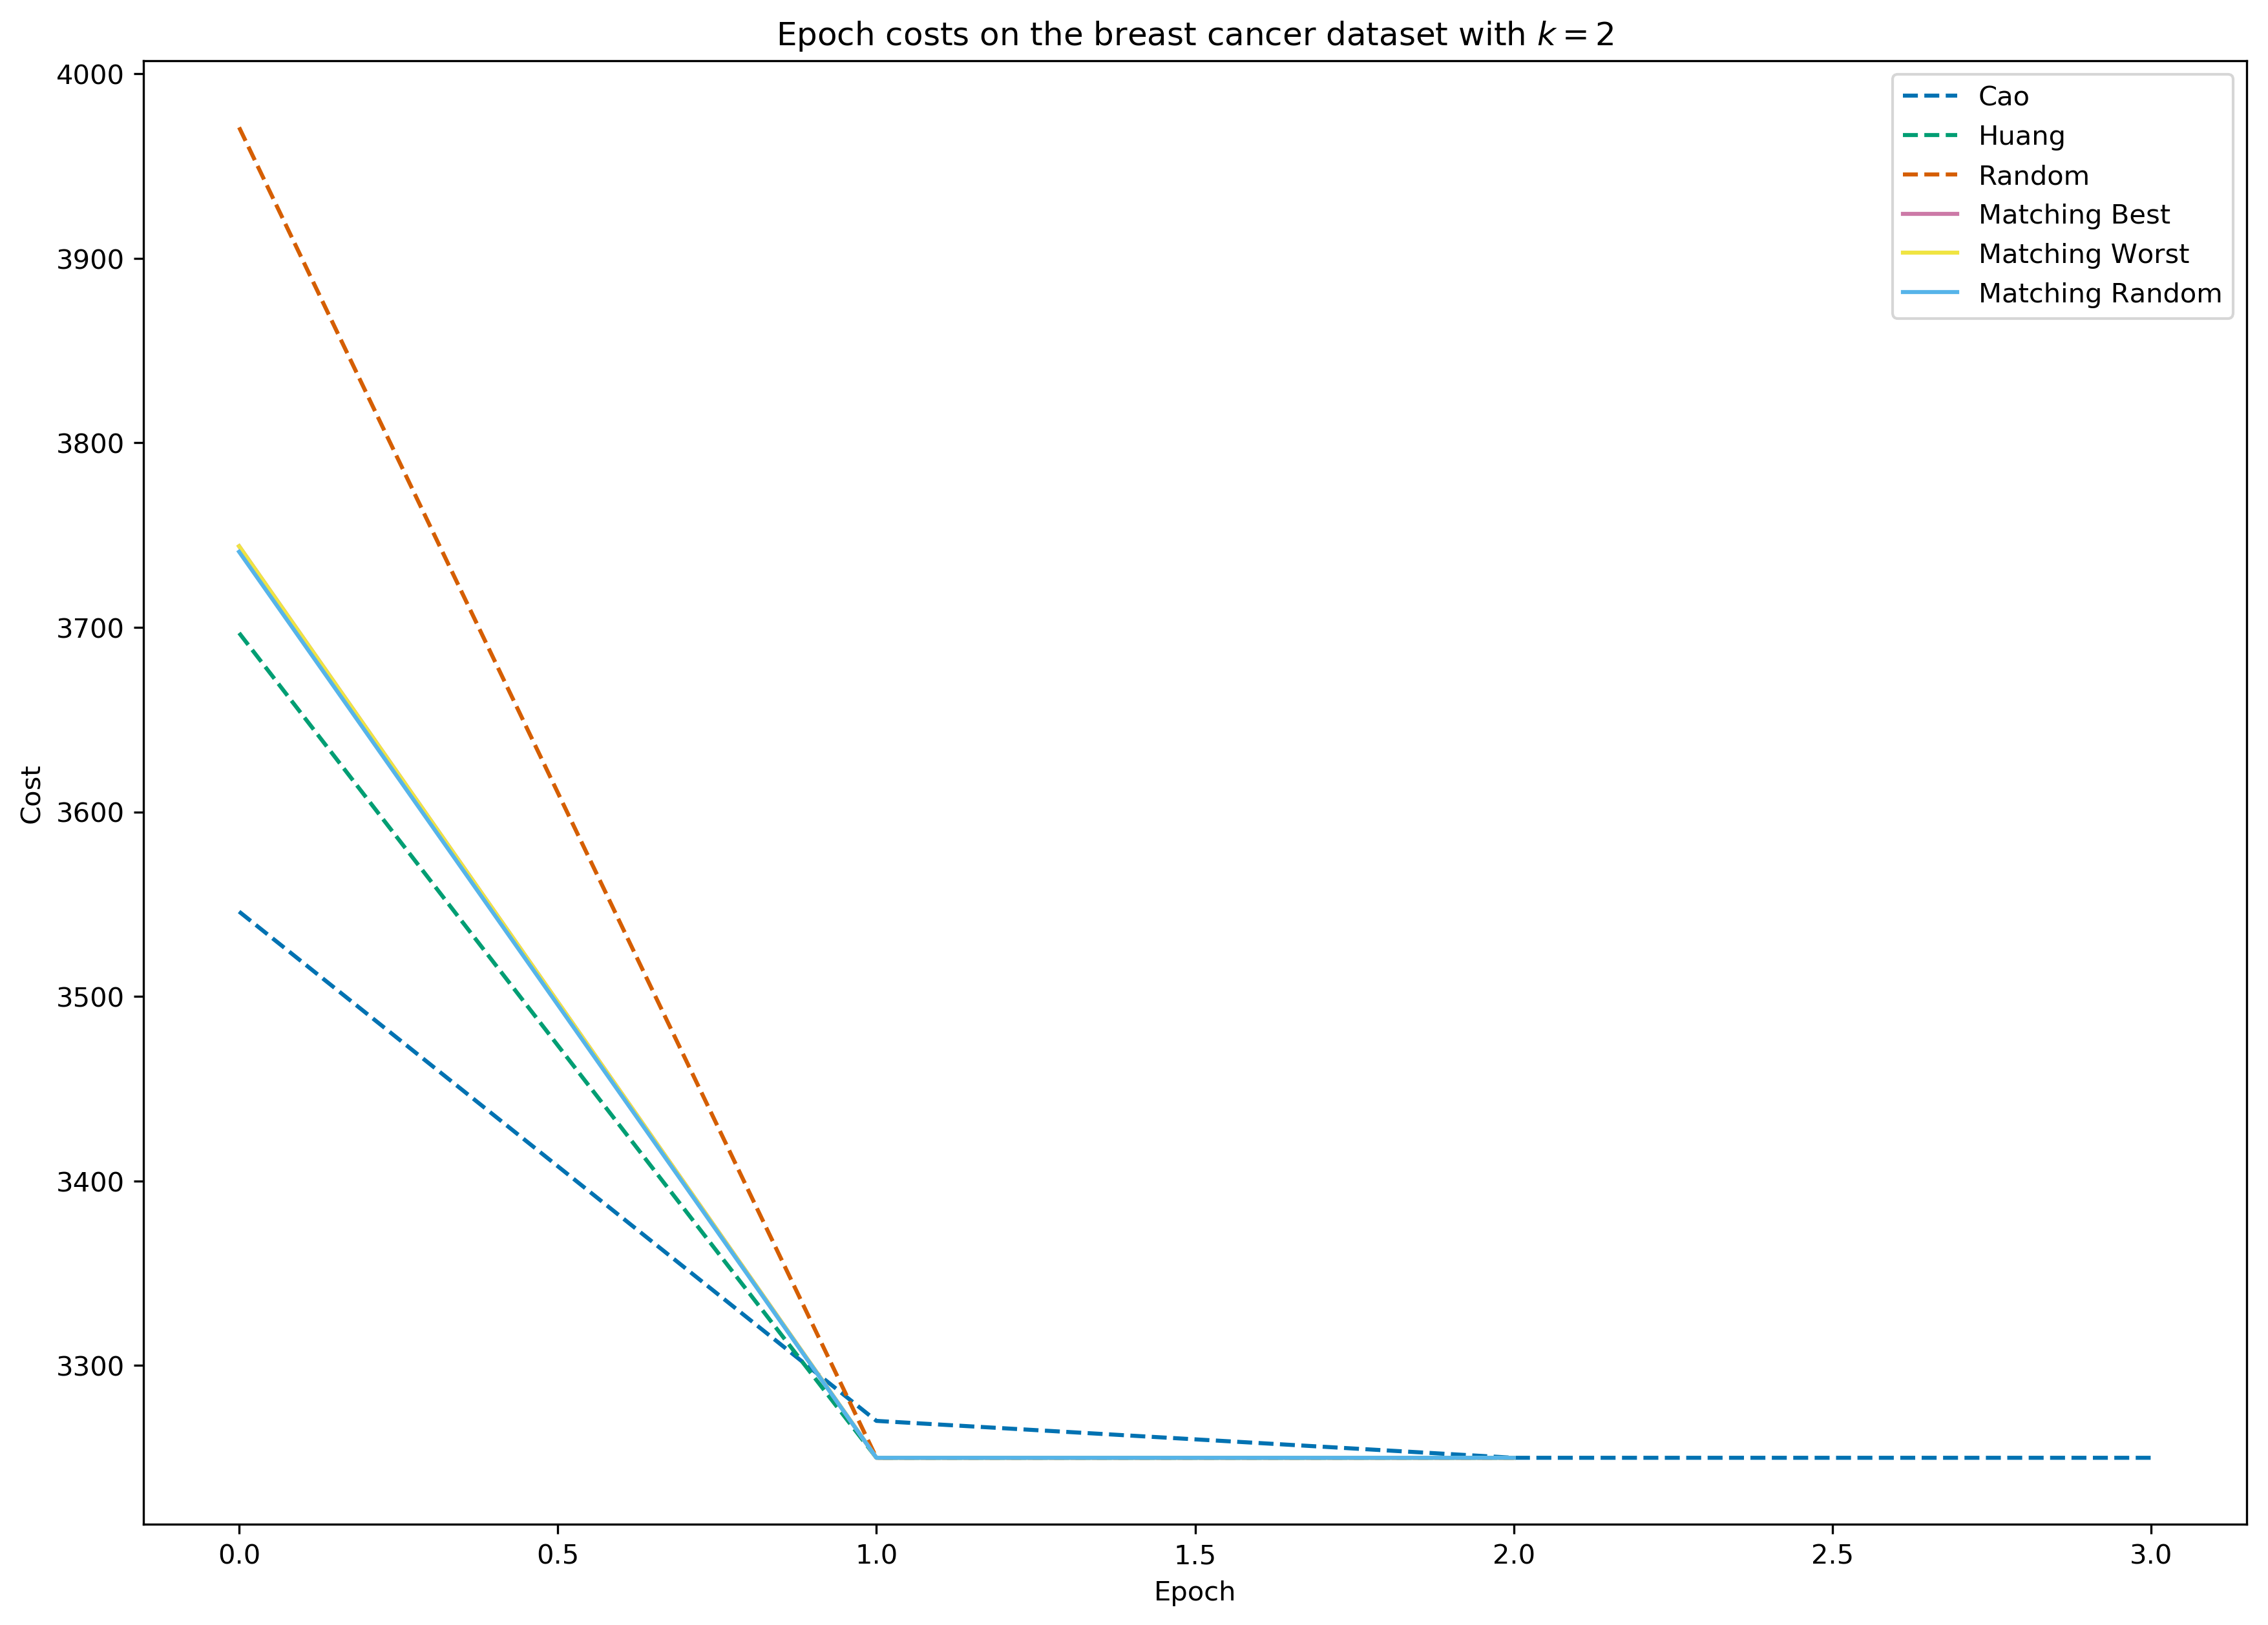

In [21]:
get_epoch_plot(breast_cancer, 'breast cancer')

# Define functions to get results tables

In [66]:
def pairwise_dissim(X, Y):

    return np.sum(X != Y, axis=0)

def get_clustering_results(dataset, init, seed):

    np.random.seed(seed)

    data = dataset.drop('class', axis=1).values
    n_clusters = dataset['class'].nunique()

    km = KModes(n_clusters, init=init, n_init=1)
    labels = km.fit_predict(data)
    silhouette = silhouette_score(data, labels, pairwise_dissim)

    result = pd.DataFrame({'Initialisation': init.replace('_', ' ').title(),
                           'Initial cost': km.epoch_costs_[0],
                           'Final cost': km.cost_,
                           'Silhouette score': silhouette,
                           'No. of iterations': km.n_iter_}, index=[''])
    return result

def format_results(results):

    mean_df = results.groupby('Initialisation').mean().reset_index()
    mean_df[''] = 'mean'

    std_df = results.groupby('Initialisation').std().reset_index()
    std_df[''] = 'std'

    median_df = results.groupby('Initialisation').median().reset_index()
    median_df[''] = 'median'
    
    return pd.concat([mean_df, std_df, median_df]).groupby(['Initialisation', '']).sum().T.round(4)

def get_init_results(data, init, max_seed):

    dfs = []
    for seed in range(max_seed):
        result = get_clustering_results(data, init, seed)
        dfs.append(result)

    return pd.concat(dfs)

def get_results_table(dataset, name, max_seed=25):

    clust_results = []
    for init in ['cao', 'huang', 'random', 'matching_best', 'matching_worst', 'matching_random']:
        clust_result = get_init_results(dataset, init, max_seed)
        clust_results.append(clust_result)

    results = format_results(pd.concat(clust_results)).reindex(['No. of iterations', 'Initial cost',
                                                                'Final cost', 'Silhouette score'])
    results.T.to_latex(f'../tex/{name.replace(" ", "_")}_results.tex')

# Collect results

In [ ]:
get_results_table(soybean, 'soybean')

In [61]:
get_results_table(mushroom, 'mushroom')

ValueError: labels ['class'] not contained in axis

In [ ]:
get_results_table(zoo, 'zoo animal')

In [ ]:
get_results_table(breast_cancer, 'breast cancer')

In [58]:
np.random.seed(0)
data = mushroom.drop('class', axis=1).values

km = KModes(n_clusters=mushroom['class'].nunique(), init='cao', n_init=1)
km.fit_predict(data)
km.cost_

62644.0